In [4]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from Extract_Observation_Tem import extract_observation_tem
print(tf.__version__)

2.4.1


In [6]:
# 获取观测数据
Years = ['1997', '1998', '1999', '2000', '2001', '2002', '2003',
         '2004', '2005', '2006', '2007', '2008', '2009', '2010']
Years = ['2007']
merge_dataset = extract_observation_tem(Years)
merge_dataset


# # 将'Rain'列转换为离散数值
# merge_dataset['Rain'] = pd.Categorical(merge_dataset['Rain'])
# merge_dataset['Rain'] = merge_dataset.Rain.cat.codes
# # 去除空数据
# merge_dataset[merge_dataset < - 1000] = np.nan
# merge_dataset.dropna(inplace=True)
# merge_dataset.head(5)

,1965,2065,2165,2265,2365,2465,2565,2665,2765,2865,...,9715,9965,10215,10465,10715,10965,11215,11465,11715,11965
2007/01/01:00,255.67122,255.35693,255.04204,254.72638,254.41011,254.09320,253.77563,253.45731,253.00804,252.31567,...,220.75304,220.19000,219.61714,219.03593,218.45021,217.80186,217.11848,216.42972,215.73553,215.03563
2007/01/01:12,258.08395,257.55347,257.02170,256.48889,255.95493,255.41978,254.88353,254.34608,253.74075,253.05260,...,220.06497,219.68169,219.29555,218.91826,218.55850,218.22728,217.90698,217.58421,217.25894,216.93097
2007/01/02:00,259.45209,259.16241,258.87219,258.58133,258.28979,257.99771,257.70502,257.41159,256.84854,255.95511,...,222.22005,221.79567,221.36815,220.93739,220.50331,219.84230,218.86607,217.88228,216.89064,215.89090
2007/01/02:12,257.11594,256.56647,256.01584,255.46407,254.91106,254.35692,253.80164,253.24509,252.47868,251.59810,...,220.86247,220.29863,219.73048,219.15800,218.57851,217.76860,216.88902,216.00235,215.10863,214.20755
2007/01/03:00,257.16742,256.80511,256.44214,256.07834,255.71378,255.34840,254.98235,254.61539,254.06540,253.36493,...,221.88380,221.21414,220.54401,219.87025,219.19135,218.35301,217.35338,216.34578,215.33015,214.30623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007/12/29:12,260.19635,259.94696,259.69708,259.44669,259.19574,258.94427,258.69232,258.43979,258.08936,257.44553,...,220.17212,218.52802,216.87157,215.20238,213.52026,211.82484,210.88539,210.15643,209.42148,208.68044
2007/12/30:00,259.20969,259.32019,259.43100,259.54196,259.65317,259.76468,259.87637,259.98831,259.76407,259.12766,...,216.83438,215.24277,213.63898,212.02261,210.39343,208.82391,208.38765,207.94777,207.50421,207.05696
2007/12/30:12,259.71918,259.55444,259.38931,259.22391,259.05811,258.89200,258.72546,258.55862,258.20972,257.52222,...,218.58743,217.30531,216.01337,214.71146,213.39925,212.07651,211.05722,210.03612,209.00662,207.96846
2007/12/31:00,255.95076,256.01379,256.07715,256.14050,256.20413,256.26773,256.33157,256.39557,256.34402,255.63647,...,218.21289,217.04465,215.86758,214.68132,213.48581,212.31686,211.36179,210.39903,209.42825,208.44946


In [5]:
# # 选择非夏季数据
# Summer = ['06', '07', '08', '09']
# for i in merge_dataset.index:
#     if(i[5:7]  in Summer):
#         merge_dataset.drop(i, inplace=True)

,10,Tamb(K),Rh(%),Pres(mb),Tir(K),Rain,Azim,Elev,TkBB(K),22.235,...,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
2007/05/20:08,11.0,289.57,62.45,804.9,223.2,0,0.0,90.0,297.660667,32.769115,...,220.18768,218.97235,217.74808,216.51433,215.28030,214.05748,212.83807,212.23833,211.63383,211.02440
2007/05/24:08,11.0,279.08,74.17,793.8,226.2,0,0.0,90.0,289.458000,14.786136,...,221.40196,220.00554,218.59877,217.18135,215.75310,214.31364,212.86284,211.61250,210.50641,209.39125
2007/05/25:08,11.0,286.53,33.33,793.2,268.7,0,0.0,90.0,295.267333,25.726204,...,221.68419,220.28036,218.86589,217.44054,216.00888,214.58099,213.14178,211.88544,210.71933,209.54366
2007/05/28:08,11.0,287.77,50.52,793.2,223.2,0,0.0,90.0,297.704667,29.413485,...,221.37656,220.12466,218.89439,217.65501,216.40623,215.14769,213.87936,212.51764,211.12653,209.72412
2007/05/29:08,11.0,289.49,66.14,793.2,274.1,0,0.0,90.0,297.897667,50.216915,...,219.00511,217.45688,215.89702,214.32520,212.74117,211.14464,209.53534,208.51392,207.74283,206.96544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010/12/27:20,11.0,267.62,50.78,793.9,250.7,0,0.0,90.0,279.020000,6.631278,...,215.85490,216.02132,216.18906,216.35808,216.12587,215.35439,214.57669,213.79280,213.03169,212.72528
2010/12/28:20,11.0,269.21,37.40,793.8,253.0,0,0.0,90.0,281.040000,6.639155,...,216.10416,215.63414,215.16040,214.68292,214.21384,213.85042,213.48415,213.11491,212.74275,212.36743
2010/12/29:20,11.0,263.38,50.46,799.6,250.1,0,0.0,90.0,275.610000,6.726363,...,217.05020,216.34125,215.62682,214.90686,214.18115,213.29092,212.35858,211.41869,210.47110,209.51558
2010/12/30:20,11.0,265.49,49.50,793.9,252.0,0,0.0,90.0,276.360000,6.473091,...,217.43681,216.75111,216.06010,215.36368,214.66170,213.61534,212.41479,211.20444,209.98410,208.75346


Index(['10', 'Tamb(K)', 'Rh(%)', 'Pres(mb)', 'Tir(K)', 'Rain', 'Azim', 'Elev',
       'TkBB(K)', ' 22.235', ' 23.035', ' 23.835', ' 26.235', ' 30.000',
       ' 51.250', ' 52.280', ' 53.850', ' 54.940', ' 56.660', ' 57.290',
       ' 58.800', '0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60',
       '0.70', '0.80', '0.90', '1.00', '1.25', '1.50', '1.75', '2.00', '2.25',
       '2.50', '2.75', '3.00', '3.25', '3.50', '3.75', '4.00', '4.25', '4.50',
       '4.75', '5.00', '5.25', '5.50', '5.75', '6.00', '6.25', '6.50', '6.75',
       '7.00', '7.25', '7.50', '7.75', '8.00', '8.25', '8.50', '8.75', '9.00',
       '9.25', '9.50', '9.75', '10.00'],
      dtype='object')

In [7]:
# 数据筛选
# '10', 'Tamb(K)', 'Rh(%)', 'Pres(mb)', 'Tir(K)', 'Rain', 'Azim', 'Elev', 'TkBB(K)'
# merge_dataset.drop(['10', 'Rain', 'TkBB(K)', 'Rh(%)', 'Pres(mb)', 'Tir(K)', 'Azim', 'Elev',], axis=1, inplace=True)
# ' 22.235', ' 23.035', ' 23.835', ' 26.235', ' 30.000', ' 51.250', ' 52.280', ' 53.850', ' 54.940', ' 56.660', ' 57.290', ' 58.800'
# merge_dataset.drop([' 22.235', ' 23.035', ' 23.835', ' 26.235', ' 30.000'], axis=1, inplace=True)

# merge_dataset.drop(['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00'], axis=1, inplace=True)
# merge_dataset.drop(['1.25', '1.50', '1.75', '2.00', '2.25', '2.50', '2.75', '3.00', '3.25', '3.50', '3.75'], axis=1, inplace=True)
# merge_dataset.drop(['4.00', '4.25', '4.50', '4.75', '5.00', '5.25', '5.50', '5.75', '6.00', '6.25', '6.50'], axis=1, inplace=True)
# merge_dataset.drop(['6.75', '7.00', '7.25', '7.50', '7.75', '8.00', '8.25', '8.50', '8.75', '9.00', '9.25'], axis=1, inplace=True)
# merge_dataset.drop(['9.50', '9.75', '10.00'], axis=1, inplace=True)



In [8]:
# 保留小数位
merge_dataset = merge_dataset.round(1)
# 归一化
def norm(x):
    return (x - merge_dataset.describe().transpose()['mean']) / merge_dataset.describe().transpose()['std']
merge_dataset.iloc[:, :8] = norm(merge_dataset).iloc[:, :8]

In [9]:
# 乱序，分离训练数据与测试数据
train_data = merge_dataset.sample(frac=0.8, random_state=0)
test_data = merge_dataset.drop(train_data.index)
# 分离标签
train_labels = train_data.iloc[:, 8:]
test_labels = test_data.iloc[:, 8:]
train_data.drop(train_labels.columns, axis=1, inplace=True)
test_data.drop(train_labels.columns, axis=1, inplace=True)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(788, 8) (197, 8) (788, 47) (197, 47)


In [10]:
def build_model():
    My_model = keras.Sequential([
        layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
        layers.Dense(47, activation='relu'),
        layers.Dense(47)
    ])

    opt = tf.optimizers.Adam(1e-3)
    # tf.train.GradientDescentOptimizer(0.001)
    # tf.keras.optimizers.RMSprop(0.001)
    # tf.optimizers.Adam(1e-3)

    My_model.compile(loss='mse',
                     optimizer=opt,
                     metrics=['mae', 'mse']
                     )
    return My_model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 47)                423       
_________________________________________________________________
dense_2 (Dense)              (None, 47)                2256      
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(train_data,
                    train_labels,
                    batch_size=32,
                    epochs=2000,
                    verbose=0,
                    validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

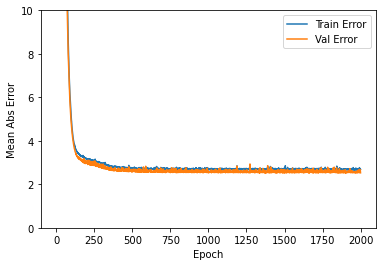

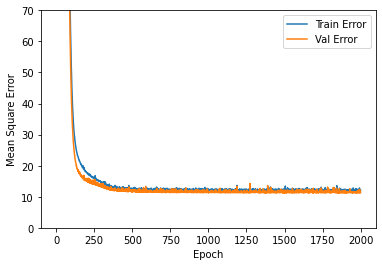

In [12]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.ylim([0, 10])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.ylim([0, 70])
    plt.legend()
    plt.show()
plot_history(history)

In [13]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=1)

print("MAE: {:5.2f} ".format(mae))
print("MSE: {:5.2f} ".format(mse))
print("LOSS: {:5.2f} ".format(loss))

7/7 [==============================] - 0s 4ms/step - loss: 13.7488 - mae: 2.8604 - mse: 13.7488
MAE:  2.86 
MSE: 13.75 
LOSS: 13.75 


In [14]:
r1 = 0
for i in range(10):
    r = np.corrcoef(model.predict(test_data[i:i + 1]), test_labels[i:i + 1])
    r1 += r[0, 1]
# print(r1/10)
print('相关系数 {:.4}'.format(r1 / 10))

相关系数 0.9963


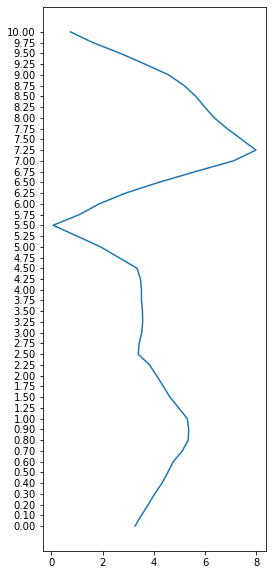

相关系数0.9936
2010/04/08:08    0.5661
dtype: float64




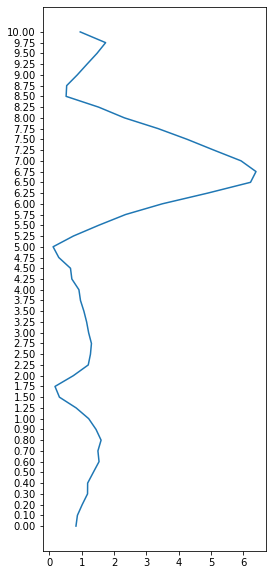

相关系数0.9924
2009/12/27:08    1.2497
dtype: float64




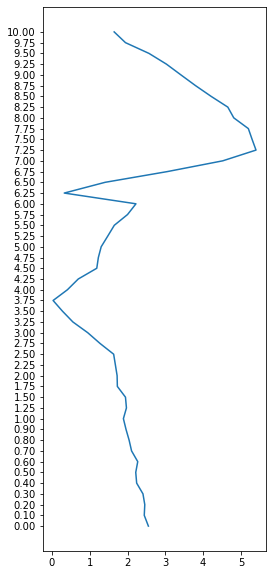

相关系数0.9939
2010/11/05:20    1.718
dtype: float64




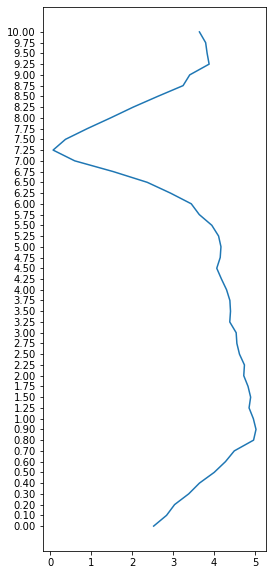

相关系数0.992
2010/12/05:08    2.3057
dtype: float64




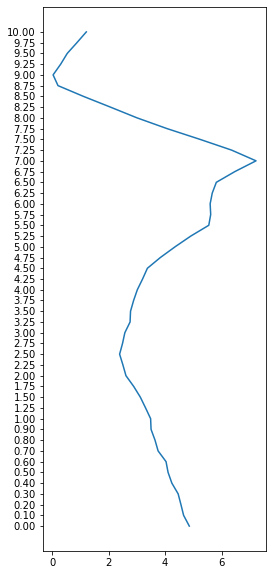

相关系数0.9945
2009/04/03:08    3.3896
dtype: float64




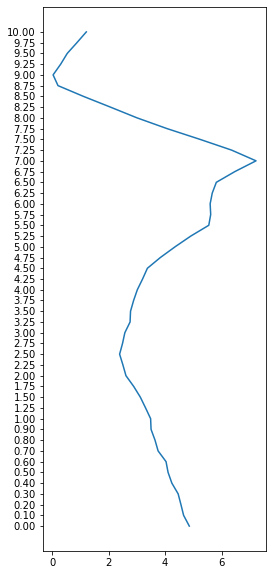

相关系数0.9945
2009/04/03:08    3.3896
dtype: float64




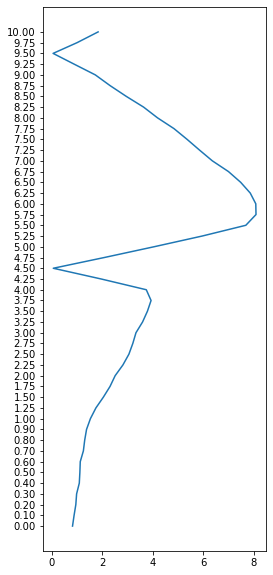

相关系数0.9782
2007/12/12:20    0.9193
dtype: float64




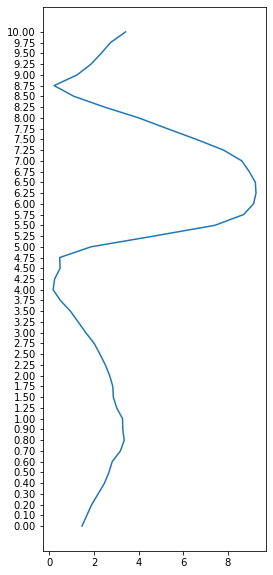

相关系数0.9806
2009/02/16:08    2.8327
dtype: float64




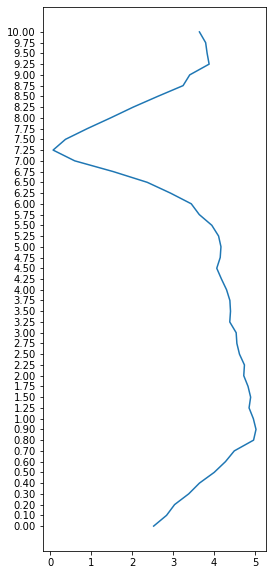

相关系数0.992
2010/12/05:08    2.3057
dtype: float64




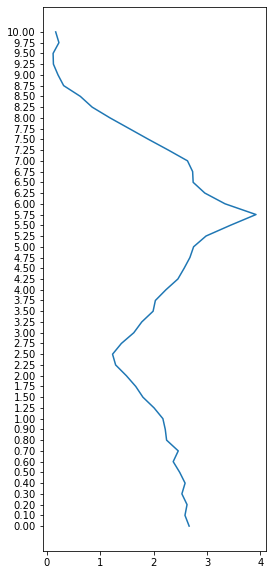

相关系数0.9984
2009/12/02:08    1.964
dtype: float64




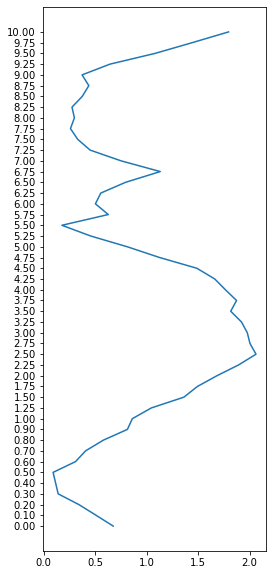

相关系数0.9984
2010/11/14:08    0.3277
dtype: float64




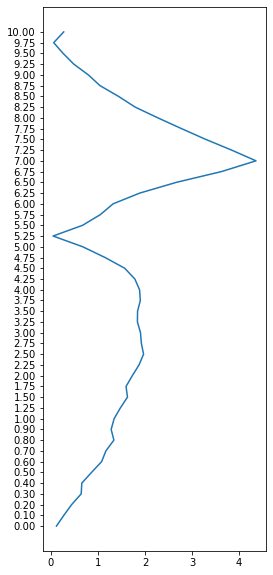

相关系数0.9968
2010/11/12:08    0.0557
dtype: float64




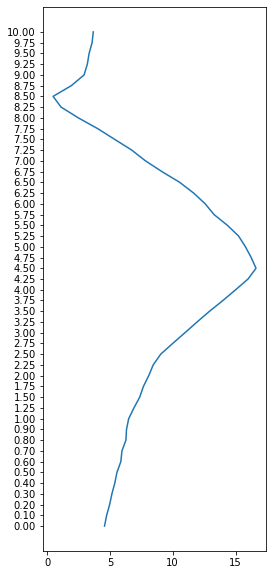

相关系数0.9412
2007/12/29:20    7.3089
dtype: float64




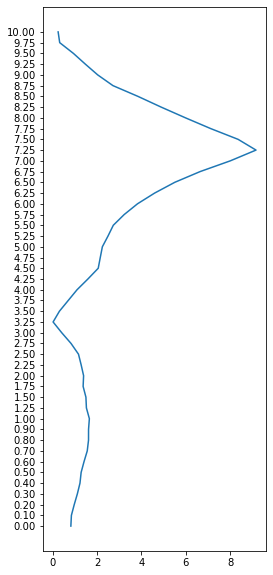

相关系数0.9954
2010/04/09:08    1.4939
dtype: float64




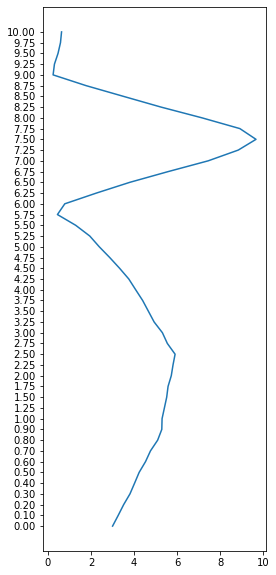

相关系数0.9897
2010/03/28:08    1.2456
dtype: float64




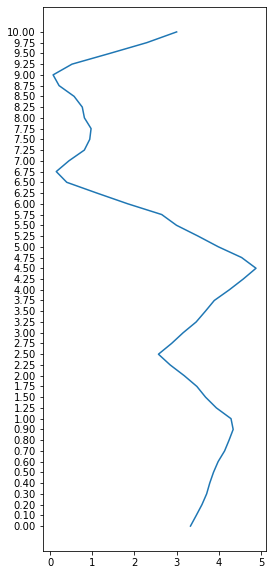

相关系数0.9977
2009/10/25:20    2.4631
dtype: float64




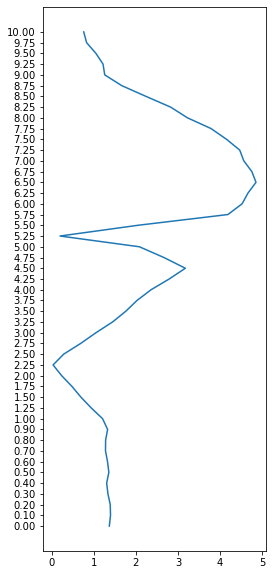

相关系数0.9932
2007/11/10:20    1.1365
dtype: float64




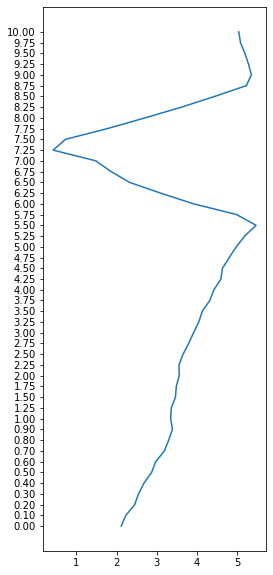

相关系数0.9857
2010/04/02:20    1.7033
dtype: float64




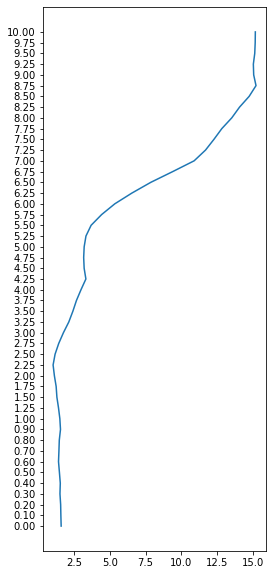

相关系数0.9865
2010/02/01:08    5.7775
dtype: float64




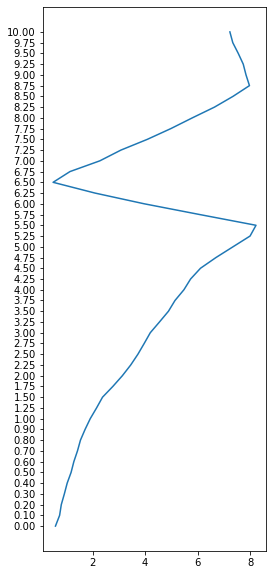

相关系数0.9607
2007/12/21:20    0.6954
dtype: float64




In [15]:
for i in range(20):
    flag = random.randrange(0, 200)
    fig = plt.figure(figsize=(4, 10))
    Height = test_labels.columns
    X1 = model.predict(test_data[flag:flag + 1]).T
    X2 = test_labels[flag:flag + 1].T
    plt.plot(np.abs(X1 - X2), Height)
    # plt.plot(X1, Height)
    # plt.plot(X2, Height)
    plt.show()
    print('相关系数{:.4}'.format(np.corrcoef(X1.T, X2.T)[0, 1]))
    # print('平均偏差{:.4}'.format((X1-X2).mean().values))
    # print(np.corcoef(X1.T,X2.T))
    print(np.abs(np.mean(X1 - X2).round(4)))
    print('\n')